# Activation stats

In [3]:
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [4]:
import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [5]:
%matplotlib inline

In [6]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [38]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 64

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

# @inplace
# def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

tds = dsd.with_transform(transformi)
# dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

In [39]:
tds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [40]:
dls

In [41]:
xb,yb=next(iter(dt))
xb.shape, yb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

## Baseline

In [42]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

We want to train quickly, so that means training at a high learning rate.

In [43]:
from torcheval.metrics import MulticlassAccuracy

In [44]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [45]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs + fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.662,0.898,0,train
0.757,0.667,0,eval


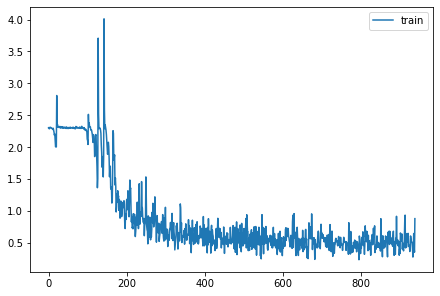

In [46]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))